In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [34]:
import skgeom as sg
from skgeom.draw import draw

In [176]:
def toPoint2(p):
    return sg.Point2(p[0], p[1])

def toVector(p1, p2):
    # Return vector witch homogeneos coordenate
    v = np.array(p1) - np.array(p2)
    return np.array([v[0], v[1], 1])

def makePoints(n, mean=0, std=1):
    #np.random.seed(21)
    xSample = np.random.normal(mean, std, n)
    ySample = np.random.normal(mean, std, n)
    return list(zip(xSample, ySample))

def list_splice(target, start, delete_count=None, *items):
    """Remove existing elements and/or add new elements to a list.

    target        the target list (will be changed)
    start         index of starting position
    delete_count  number of items to remove (default: len(target) - start)
    *items        items to insert at start index

    Returns a new list of removed items (or an empty list)
    """
    if delete_count == None:
        delete_count = len(target) - start

    # store removed range in a separate list and replace with *items
    total = start + delete_count
    removed = target[start:total]
    target[start:total] = items

    return removed

def giftWrapping(pts_):
    pts = pts_[:]
    pts.sort(key=lambda x: x[0]) # ordenamos por el eje x

    hull = []
    index = 2
    nextIndex = -1
    
    leftMost = pts[0]
    currentVertex = leftMost
    hull.append(currentVertex)
    nextVertex = pts[1]
    try:
        while True:
            #print(len(pts), index)
            checkingPoint = pts[index]
            u = toVector(nextVertex, currentVertex)
            v = toVector(checkingPoint, currentVertex)
            cross = np.cross(u, v)
            if cross[2]>0:
                nextVertex = checkingPoint
                nextIndex = index
            index += 1
            if index == len(pts):
                if nextVertex == leftMost:
                    print('Termino..')
                    return hull
                else:
                    hull.append(nextVertex)
                    currentVertex = nextVertex
                    index = 0
                    # splice..
                    _ = list_splice(pts, nextIndex, 1) #pts = pts[nextIndex:]
                    nextVertex = leftMost
    except Exception as e:
        print('Exception:', e)
        return hull
    return hull

In [180]:
n = 50
points = makePoints(n)
res = giftWrapping(points)
print(len(res))

Termino..
6


In [181]:
print(res)

[(-3.150669380410565, 0.8183156528279196), (-0.5461173410286654, 3.436042156252611), (1.5412549988262154, 1.1869789525961336), (2.177759580727675, 0.33370995749788296), (0.21494303296013414, -1.3855848549109089), (-1.488124761484556, -1.3760693103129442)]


## Plot using SKGEOM

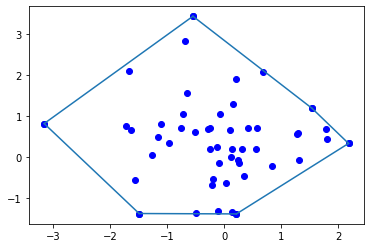

In [185]:
# plot todos los puntos que estaban previamente ordenados
# y resaltamos de color rojo el
points_sg = []
for i in range(n):
    x, y = points[i]
    points_sg.append(sg.Point2(x, y))
    
#draw(toPoint2(leftMost), color='red') # Draw only the leftMost point

#draw(sg.Segment2(toPoint2(currentVertex),toPoint2(nextVertex)))
#draw(sg.Segment2(toPoint2(currentVertex),toPoint2(checkingPoint)), color='green')
#draw(toPoint2(currentVertex), color='orange') # Draw only the currentVertex point

#res = [(-1.7110537607276717, 0.231802959660187), (-0.6132002869132012, 1.5678821766222575), (-0.6132002869132012, 1.5678821766222575), (1.3736884997604164, 1.1785562058590144), (1.6109919764383442, -1.383956868577714), (1.6109919764383442, -1.383956868577714)]
#hull_poly = sg.Polygon(res)
#draw(hull_poly)
for i in range(len(res)-1):
    draw(sg.Segment2(toPoint2(res[i]),toPoint2(res[i+1])))
draw(sg.Segment2(toPoint2(res[-1]),toPoint2(res[0])))
    
draw(points_sg, color='blue') # draw all points

In [174]:
# https://gist.github.com/WetHat/d69ce0e94e337538e5b4c848501522aa

In [136]:
arr = ['a', 'b', 'c', 'd', 'e', 'f']
removed = list_splice(arr, 2, 1)
print(arr)

['a', 'b', 'd', 'e', 'f']


In [141]:
removed = list_splice(arr, -1, 1)
print(arr)

['a', 'e', 'f']
